# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

Student Name: Michael Doherty

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [2]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'south'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`.

In [3]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [4]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: east
step 1 - action: south
step 2 - action: south
step 3 - action: east
step 4 - action: east
step 5 - action: east
step 6 - action: suck
step 7 - action: south
step 8 - action: west
step 9 - action: north
step 10 - action: west
step 11 - action: east
step 12 - action: north
step 13 - action: east
step 14 - action: west
step 15 - action: south
step 16 - action: south
step 17 - action: west
step 18 - action: west
step 19 - action: south


1

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [5]:
from pprint import pprint # import pretty print for data output
rng = np.random.default_rng() # global random number generator

def simulation_environment(agent, size=5, max_steps=999999, verbose=True):
    # the room the agent is cleaning
    room = rng.choice(['dirty', 'clean'], 
                      size = (size,size), 
                      p = [0.2, 0.8])
    
    if verbose:
        print('Room layout:')
        print(room)
    
    # the current number of dirty squares
    dirty_count = np.count_nonzero(room == 'dirty')

    # the history of actions the agent takes
    actions = []
    
    # the number of actions the agent takes
    num_actions = 0
    
    # where the agent is currently located
    agent_position = (rng.integers(0, size), rng.integers(0, size)) 
    
    min = 0
    max = size - 1

    for i in range(max_steps):
        row, col = agent_position
        dirty = True if room[row][col] == 'dirty' else False
        bumpers = {"north" : True if row == min else False,
                   "south" : True if row == max else False,
                   "west"  : True if col == min else False,
                   "east"  : True if col == max else False}

        action = agent(bumpers, dirty) # get the agent's action
        if verbose: 
            print("step", i , '- current position:', agent_position, "- action:", action)
            
        actions.append(action)
        
        # apply the agent's action
        if action == 'north' and row != min:
            row -= 1
        elif action == 'south' and row != max:
            row += 1
        elif action == 'west' and col != min:
            col -= 1
        elif action == 'east' and col != max:
            col += 1
        elif action == 'suck' and dirty:
            room[row][col] = 'clean'
            dirty_count -= 1
            
        agent_position = (row, col) # update the agent's position
        
        num_actions += 1 # increment number of actions
        
        if dirty_count == 0: # agent stops when the whole room is clean
            break

    if verbose:
        print('History of actions:')
        pprint(actions)
            
    return num_actions

print('Randomized Agent Number of Actions:', simulation_environment(simple_randomized_agent, verbose=False))

Randomized Agent Number of Actions: 323


# simulation_environment Explanation
My simulation environment works by first generating an n x n room with a given size (the default size is 5). Each generated tile in the room has a 20% chance of being dirty. My simulation environment then counts the initial number of dirty tiles in the room and keeps track of this number. The agent's starting position is then randomly generated. After this, the simulation environment begins a loops that runs for at most max_steps number of times (max_steps is defaulted to 999,999). For each iteration, the environment gets the agent's current location, checks if the current tile is dirty, and sets the agent's bumper sensors. It then gives the agent these percepts and receives the agent's action. It then applies this action to the board, updates any variables that need to be updated (like the agent's position or a tile's 'clean'/'dirty' status), and checks if there are any dirty tiles left in the room. If all tiles in the room are clean, then the function returns the number of actions the agent took.

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [6]:
def simple_reflex_agent(bumpers, dirty):
    if dirty: # if the current tile is dirty, then clean it
        return 'suck'
    
    # filters out invalid moves and randomly chooses a valid one
    possible_actions = [key for key, value in bumpers.items() if value != True]
    choice = rng.integers(0, len(possible_actions))
    return possible_actions[choice]

 
print('Simple Reflex Agent Number of Actions:', simulation_environment(simple_reflex_agent, verbose=False))

Simple Reflex Agent Number of Actions: 60


# simple_reflex_agent Explanation
My Simple Reflex Agent first checks if dirty is True (indicating the tile it is currently on is dirty). If this is True, then it will clean the tile. If dirty is False, then my Simple Reflex Agent filters out any invalid moves; it does this by checking its bumpers. If any bumpers are set to True, then it will not consider moving in that direction (as the bumper being True means there is a wall or obstacle in that direction). After creating a list of valid moves, it then randomly chooses one of these actions.

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

For my Model-Based Reflex Agent, the **agent state** is defined as:
- **The agent's position:** This is initially set to (None, None), as the agent doesn't know where it is at first. However, once the agent has found its way to (0, 0), it will keep track of its current position.
- **The agent's direction:** This is initially set to None; once the agent makes it to the northwest corner of the room (0, 0), then it will zig-zag throughout the room, cleaning any dirty tiles as it goes. The agent's direction is set to either 'east' or 'west', depending on which direction it is heading on the row it is currently on.

My Model Based Reflex Agent works by first finding its position in the room. It does this by navigating to the northwest corner (0, 0); it knows it has reached this point when it's bumpers for 'north' and 'west' are both True. It then will zig-zag throughout the room, heading 'east' on the first row, then moving down to the next row and heading 'west', then moving down to the next row and heading 'east', etc. until it has cleaned all dirty spots in the room. The agent knows it has reached the end of its current row when its bumper of the direction it is heading in is True (for example, when it is heading 'east' on the first row, when bumpers['east'] is True, then it knows it needs to move down to the next row and head 'west').

In [7]:
class Model_Based_Reflex_Agent:
    def __init__(self): 
        self.position = (None, None) # keeps track of the agent's current position
        self.direction = None # keeps track of the agent's direction (when in it's zig-zag pattern)
    
    def act(self, bumpers, dirty):
        if dirty: # clean a tile if it's dirty
            return 'suck'
        
        row, col = self.position
        
        if row is None: # if the agent doesn't know what row it is on
            if bumpers['north']: # when it has reached the top row
                row = 0
                self.position = (row, col)
            else:
                return 'north'
            
        if col is None: # if the agent doesn't know what column it is on
            if bumpers['west']: # when it has reached the leftmost column
                col = 0
                self.position = (row, col)
            else:
                return 'west'
        
        if self.position == (0, 0): # begins zig-zag pattern when in northwest corner
            self.direction = 'east'
            self.position = (row, col + 1)
            return self.direction
        
        if not bumpers[self.direction]: # move across each row
            self.position = (row, col + 1) if self.direction == 'east' else (row, col - 1)
            return self.direction
        else: # when the end of a row is reached, go to the next row
            self.direction = 'west' if self.direction == 'east' else 'east'
            self.position = (row + 1, col)
            return 'south'
            

model_based_reflex_agent = Model_Based_Reflex_Agent()
print('Model-Based Reflex Agent Number of Actions:', simulation_environment(model_based_reflex_agent.act, verbose=False))

Model-Based Reflex Agent Number of Actions: 10


## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [8]:
random_agent_5x5 = []
reflex_agent_5x5 = []
model_based_agent_5x5 = []

random_agent_10x10 = []
reflex_agent_10x10 = []
model_based_agent_10x10 = []

random_agent_100x100 = []
reflex_agent_100x100 = []
model_based_agent_100x100 = []

for i in range(100): # runs 100 simulations for each type of agent on each board size
    random_agent_5x5.append(simulation_environment(simple_randomized_agent, size=5, verbose=False))
    random_agent_10x10.append(simulation_environment(simple_randomized_agent, size=10, verbose=False))
    random_agent_100x100.append(simulation_environment(simple_randomized_agent, size=100, verbose=False))

    reflex_agent_5x5.append(simulation_environment(simple_reflex_agent, size=5, verbose=False))
    reflex_agent_10x10.append(simulation_environment(simple_reflex_agent, size=10, verbose=False))
    reflex_agent_100x100.append(simulation_environment(simple_reflex_agent, size=100, verbose=False))
    
    model_based_reflex_agent = Model_Based_Reflex_Agent()
    model_based_agent_5x5.append(simulation_environment(model_based_reflex_agent.act, size=5, verbose=False))
    model_based_reflex_agent = Model_Based_Reflex_Agent()
    model_based_agent_10x10.append(simulation_environment(model_based_reflex_agent.act, size=10, verbose=False))
    model_based_reflex_agent = Model_Based_Reflex_Agent()
    model_based_agent_100x100.append(simulation_environment(model_based_reflex_agent.act, size=100, verbose=False))
    
print('Random agent:')
print('5x5:', sum(random_agent_5x5)/len(random_agent_5x5))
print('10x10:', sum(random_agent_10x10)/len(random_agent_10x10))
print('100x100:', sum(random_agent_100x100)/len(random_agent_100x100))
print()

print('Reflex agent:')
print('5x5:', sum(reflex_agent_5x5)/len(reflex_agent_5x5))
print('10x10:', sum(reflex_agent_10x10)/len(reflex_agent_10x10))
print('100x100:', sum(reflex_agent_100x100)/len(reflex_agent_100x100))
print()

print('Model based agent:')
print('5x5:', sum(model_based_agent_5x5)/len(model_based_agent_5x5))
print('10x10:', sum(model_based_agent_10x10)/len(model_based_agent_10x10))
print('100x100:', sum(model_based_agent_100x100)/len(model_based_agent_100x100))

Random agent:
5x5: 386.26
10x10: 3203.35
100x100: 838965.24

Reflex agent:
5x5: 107.74
10x10: 835.91
100x100: 335362.8

Model based agent:
5x5: 28.24
10x10: 124.42
100x100: 12097.15


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |386.26 |107.74 |28.24 |
| 10x10   |3,203.35 |835.91 |124.42 |
| 100x100 |838,965.24 |335,362.8 |12,097.15 |

As the above chart shows, the Model-Based Reflex Agent consistently performs the best out of all 3 types of agents. Its better performance becomes more noticable as the room size increases, as the difference between its performance and the other 2 agents' performances becomes even larger. The chart also shows how the Simple Reflex Agent is clearly better than the Randomized Agent. Even though it moves around randomly, the Simple Reflex Agent will clean any dirty spots it comes across, as opposed to the Randomized Agent, who may not clean dirty spots it finds and may try to clean spots that are already clean.

Add charts to compare the performance of the different agents.

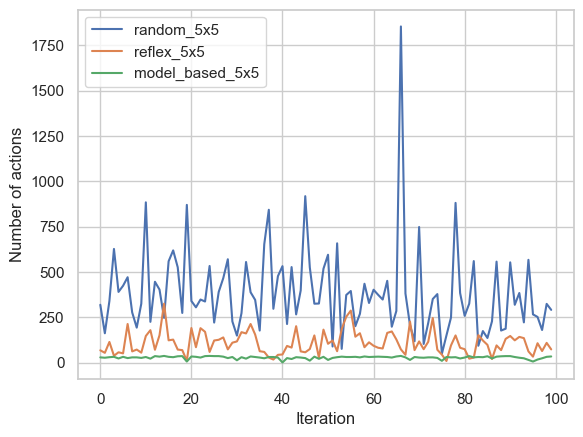

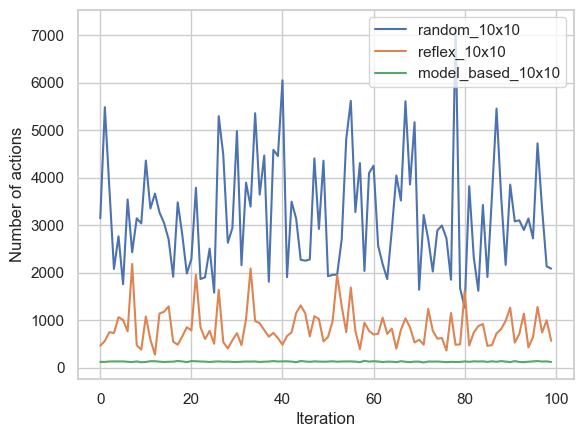

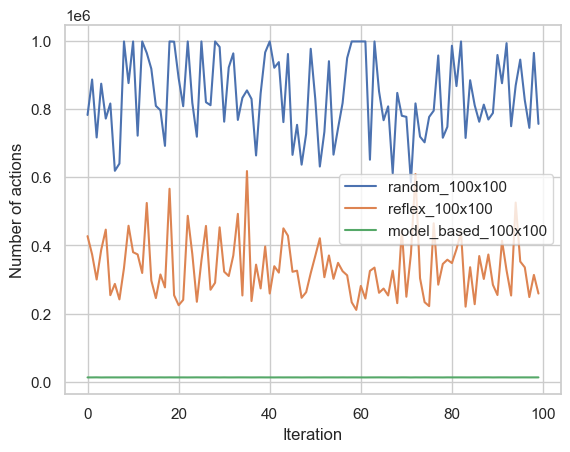

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") # adds grid lines
x = range(100)

# the plot comparing the agents' performances in a 5x5 room
plt.plot(x, random_agent_5x5, label="random_5x5") 
plt.plot(x, reflex_agent_5x5, label="reflex_5x5") 
plt.plot(x, model_based_agent_5x5, label="model_based_5x5")

plt.xlabel("Iteration")
plt.ylabel("Number of actions")
plt.legend()
plt.show()

# the plot comparing the agents' performances in a 10x10 room
plt.plot(x, random_agent_10x10, label="random_10x10") 
plt.plot(x, reflex_agent_10x10, label="reflex_10x10") 
plt.plot(x, model_based_agent_10x10, label="model_based_10x10")

plt.xlabel("Iteration")
plt.ylabel("Number of actions")
plt.legend()
plt.show()

# the plot comparing the agents' performances in a 100x100 room
plt.plot(x, random_agent_100x100, label="random_100x100") 
plt.plot(x, reflex_agent_100x100, label="reflex_100x100") 
plt.plot(x, model_based_agent_100x100, label="model_based_100x100")

plt.xlabel("Iteration")
plt.ylabel("Number of actions")
plt.legend()
plt.show()

As the above plots show, the Simple Randomized Agent consistently performed the worst across all 3 room sizes (which we would expect, as its behavior is not rational). The Simple Reflex Agent is the second best, but it still does not perform particularly well (as it cleans any dirty spots it finds, but it moves around randomly and has no memory of where it's been before). Finally the model based agent is by far the best (especially on a room size of 100x100). Comparing the three agents' performances, it is clear that the model based agent's ability to figure out its current location and navigate throughout the room makes it significantly more efficient at cleaning each room.

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

**If it is put into a rectangular room with unknown size**
- The **Randomized Agent** would still perform the worst. Its irrational behavior means that it will still be inefficient at cleaning any room, regardless of its size.
- The **Simple Reflex Agent** would perform the second best. It acts rationally by cleaning any dirty spots it finds; however, it cannot remember where it's been or what its current location is. Thus, since it cannot determine how big the room it is in is anyway, the room's unknown size won't have a drastic impact on how it performs, leading it to still perform second best.
- The **Model-Based Reflex Agent** would perform the best. It would still navigate to the nortwest corner of the room and proceed to zig-zag throughout the room, cleaning all dirty tiles in the room. In addition, its agent state allows it to keep track of its position, meaning it could determine the size of the room while it is cleaning it.

**If the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms)**
- The **Randomized Agent** would still perform the worst. Its irrational behavior means that it will still be inefficient at cleaning any room, regardless of its irregular shape. Its performance would probably not be drastically affected by the room's irregular shape, so it would perform similiarly to any other room that has the same number of tiles.
- The **Simple Reflex Agent** would perform the second best. It acts rationally by cleaning any dirty spots it finds; the room's irregular shape won't have a drastic impact on how it performs, leading it to perform similiarly to any other regularly-shaped room that has the same number of tiles.
- The **Model-Based Reflex Agent** would still generally perform the best, if it had some minor modifications. It would still navigate to the nortwest corner of the room and proceed to zig-zag throughout the room, cleaning all dirty tiles as it goes. However, it would need some minor modifications depending on how irregular the shape of the room is; for example, if the hallway it was in had smaller "subrooms" off the hallway, it would need to understand how to navigate out of these "subrooms" so it doesn't get stuck in one of their corners. Nevertheless, its ability to know it's current location would allow it to perform the best (albeit, with some minor modifications).

**If the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors)**
- The **Randomized Agent** would still perform the worst. Its irrational behavior means that it will still be inefficient at cleaning any room, regardless of if there were obstacles.
- The **Simple Reflex Agent** would perform the second best. It acts rationally by cleaning any dirty spots it finds; however, it cannot remember where it's been or what its current location is. Since it cannot determine the layout of the room it is in, the obstacles would likely slow it down, but its random movements would allow it to eventually navigate throughout the entire room, cleaning it in the process.
- The **Model-Based Reflex Agent** would perform the best, although it would need some modifications to do so. It would still navigate to the nortwest corner of the room and proceed to zig-zag throughout the room; however, with obstacles in the room, it would need a way to determine whether it has actually reached the northwest corner, or if it has simply reached a point where it is blocked by 2 obstacles. I would likely try to implement this by using information from the agent's bumper sensors to determine if it has found a corner of the room, or simply found obstacles blocking its path. However, if left with its current implementation (with no modifications), my Model-Based Reflex Agent would probably perform the worst, as it would likely get stuck on obstacles and be unable to navigate to certain parts of the room.

## Graduate student advanced task: Obstacles [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

1. Change your simulation environment to run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can.

In [10]:
# defines a simulation environment, where 20% of squares are dirty and 10% of squares have obstacles
def simulation_environment_with_obstacles(agent, size=5, max_steps=999999, verbose=True):
    # the room the agent is cleaning
    room = rng.choice(['dirty', 'clean', 'obstacle'], 
                      size = (size,size), 
                      p = [0.2, 0.7, 0.1])
    
    if verbose:
        print('Room layout:')
        print(room)
    
    # the current number of dirty squares
    dirty_count = np.count_nonzero(room == 'dirty')

    # the history of actions the agent takes
    actions = []
    
    # the number of actions the agent takes
    num_actions = 0
    
    # where the agent is currently located
    agent_position = (rng.integers(0, size), rng.integers(0, size)) 
    while room[agent_position] == 'obstacle': # ensures the agent doesn't start on top of an obstacle
        agent_position = (rng.integers(0, size), rng.integers(0, size))
    
    min = 0
    max = size - 1

    for i in range(max_steps):
        row, col = agent_position
        dirty = True if room[row][col] == 'dirty' else False
        bumpers = {"north" : True if row == min or room[row - 1][col] == 'obstacle' else False,
                   "south" : True if row == max or room[row + 1][col] == 'obstacle' else False,
                   "west"  : True if col == min or room[row][col - 1] == 'obstacle' else False,
                   "east"  : True if col == max or room[row][col + 1] == 'obstacle' else False}

        action = agent(bumpers, dirty) # get the agent's action
        if verbose: 
            print("step", i , '- current position:', agent_position, "- action:", action)
            
        actions.append(action)
        
        # apply the agent's action
        if action == 'north' and row != min and room[row - 1][col] != 'obstacle':
            row -= 1
        elif action == 'south' and row != max and room[row + 1][col] != 'obstacle':
            row += 1
        elif action == 'west' and col != min and room[row][col - 1] != 'obstacle':
            col -= 1
        elif action == 'east' and col != max and room[row][col + 1] != 'obstacle':
            col += 1
        elif action == 'suck' and dirty:
            room[row][col] = 'clean'
            dirty_count -= 1
            
        agent_position = (row, col) # update the agent's position
        
        num_actions += 1
        
        if dirty_count == 0: # agent stops when the whole room is clean
            break
            
    if verbose:
        print('History of actions:')
        pprint(actions)

    return num_actions

In [11]:
random_agent_5x5 = []
reflex_agent_5x5 = []
model_based_agent_5x5 = []

random_agent_10x10 = []
reflex_agent_10x10 = []
model_based_agent_10x10 = []

for i in range(10):
    random_agent_5x5.append(simulation_environment_with_obstacles(simple_randomized_agent, size=5, max_steps=25000, verbose=False))
    random_agent_10x10.append(simulation_environment_with_obstacles(simple_randomized_agent, size=10, max_steps=25000, verbose=False))

    reflex_agent_5x5.append(simulation_environment_with_obstacles(simple_reflex_agent, size=5, max_steps=25000, verbose=False))
    reflex_agent_10x10.append(simulation_environment_with_obstacles(simple_reflex_agent, size=10, max_steps=25000, verbose=False))
    
    model_based_reflex_agent = Model_Based_Reflex_Agent()
    model_based_agent_5x5.append(simulation_environment_with_obstacles(model_based_reflex_agent.act, size=5, max_steps=25000, verbose=False))
    model_based_reflex_agent = Model_Based_Reflex_Agent()
    model_based_agent_10x10.append(simulation_environment_with_obstacles(model_based_reflex_agent.act, size=10, max_steps=25000, verbose=False))
    
print('Random agent:')
print('5x5:', sum(random_agent_5x5)/len(random_agent_5x5))
print('10x10:', sum(random_agent_10x10)/len(random_agent_10x10))
print()

print('Reflex agent:')
print('5x5:', sum(reflex_agent_5x5)/len(reflex_agent_5x5))
print('10x10:', sum(reflex_agent_10x10)/len(reflex_agent_10x10))
print()

print('Model based agent:')
print('5x5:', sum(model_based_agent_5x5)/len(model_based_agent_5x5))
print('10x10:', sum(model_based_agent_10x10)/len(model_based_agent_10x10))

Random agent:
5x5: 532.9
10x10: 3191.0

Reflex agent:
5x5: 104.4
10x10: 1130.0

Model based agent:
5x5: 12512.0
10x10: 25000.0


**Note: I only ran each agent in the simulation_environment_with_obstacles 10 times to simplify things and make the runtime more reasonable. I set the max_step size for each agent to 25,000.**

As the above shows, the results for the agents in an environment **with obstacles** are:

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |532.9 |104.4 |12,512.0 |
| 10x10   |3,191.0 |1,130.0 |25,000.0 |

We can compare these to our earlier results in an environment **without obstacles**:

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |386.26 |107.74 |28.24 |
| 10x10   |3,203.35 |835.91 |124.42 |
| 100x100 |838,965.24 |335,362.8 |12,097.15 |

As we can see, the difference in performance for both the Randomized Agent and Simple Reflex Agent are relatively minor; both of these agents actually performed slightly better in the environment with obstacles on at least 1 board size. This confirms that, since the movements of both of these agents are random, the introduction of obstacles does not significantly impact their performance.

On the other hand, the Model-Based Reflex Agent performed much worse in the environment with obstacles. On the 10x10 board, the Model-Based Reflex Agent was unable to finish cleaning a single room (as the average number of actions was 25,000, which is what I made the max_step size). It also likely failed to clean several of the 5x5 rooms since its average was so high (it probably got lucky at least once and got a room where the obstacles did not stop it from cleaning all dirty squares).

Neither the Randomized Agent nor the Simple Reflex Agent need to be modified, as they are performing as best as they can in an environment with obstacles. For my Model-Based Reflex Agent, I would need to modify it so that it can determine whether its bumper sensors are sensing a wall or an obstacle. I would need to change it so that when it encounters an obstacle, it can navigate around it and continue to move in its zig-zag pattern, ensuring that all tiles in the room get cleaned.

## More advanced implementation tasks

* __Agent for an environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actually depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currently clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

## More advanced implementation tasks ideas:
- For an environment with obstacles, I would implement an agent that utilizes depth-first search. The agent would consider its starting position to be (0, 0), and it would navigate throughout the room, storing in its memory where it has already been. The agent would try to find the closest tile it has not yet checked, cleaning any dirty tiles it finds along the way. If it encountered an obstacle, the agent would simply navigate around it. Using this method, the agent would eventually be able to navigate throughout the entire room and clean it in an efficient way.
- For a utility based agent, I would have the agent first find its location and then navigate throughout the entire room. It would check each tile in the room 100 times, counting the number of times each tile is dirty. After checking each tile 100 times (which would take 2500 moves, plus a little extra for it to find its location), it would calculate the probability for each tile in the room to get dirty again. It would then prioritize moving between the tiles with a higher probability of being dirty (while also occasionally moving to tiles with a smaller probability of being dirty). It would continue to update the probabilities of each square as it visits the tiles more often. Thus, using the knowledge that it has learned, by the time it runs out of charge, it should have cleaned as many tiles as is reasonably possible.